In [734]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import scipy
import emcee
import corner

In [735]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [736]:
def generate_normal(size, mu, sigma):
    return np.random.normal(0.0, sigma, size) + mu

In [737]:
def add_normal_errors(data, sigma):
    return np.array([i + np.random.normal(0.0, sigma) for i in data])

In [738]:
def generate_two_normal(size, a, mu_1, sigma_1, mu_2, sigma_2):
    return np.hstack([np.random.normal(0.0, sigma_1, round(size*a)) + mu_1, np.random.normal(0.0, sigma_2, round(size*(1-a))) + mu_2])

(array([ 10.,  92., 215., 144.,  37.,  45., 133., 200., 101.,  23.]),
 array([-2.04162876, -0.94177268,  0.1580834 ,  1.25793949,  2.35779557,
         3.45765165,  4.55750773,  5.65736382,  6.7572199 ,  7.85707598,
         8.95693206]),
 <BarContainer object of 10 artists>)

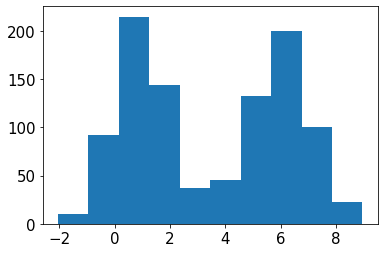

In [739]:
plt.hist(generate_two_normal(1000, 0.5, 1, 1, 6, 1))

In [740]:
def normal_cdf(x, mu, sigma):
    return 0.5*(1+scipy.special.erf((x-mu)/(sigma*np.sqrt(2))))

In [741]:
pi = float(math.pi)

def phi(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*pi))) * np.exp(-(x-mu)**2/(2*sigma**2))

In [742]:
def truncnormal_like(x, mu, sigma, lower, upper):
    #return st.truncnorm.pdf(x, a=-mu/sigma, b=100, loc = mu, scale = sigma)
    result = np.zeros(x.shape[0])
    result[np.logical_and(x<=upper, x>=lower)] = phi(x[np.logical_and(x<=upper, x>=lower)],mu,sigma)/(normal_cdf(upper,mu,sigma)-normal_cdf(lower,mu,sigma))
    result[np.logical_or(x>upper, x<lower)] = 0
    return result

In [743]:
def truncnormal_like_one(x, mu, sigma, lower, upper):
    #return st.truncnorm.pdf(x, a=-mu/sigma, b=100, loc = mu, scale = sigma)
    if x <= upper and x >= lower:
        return phi(x,mu,sigma)/(normal_cdf(upper,mu,sigma)-normal_cdf(lower,mu,sigma))
    return 0

In [744]:
def generate_truncnormal(N, mu, sigma, lower, upper): 
    return st.truncnorm.rvs(a=(lower-mu)/sigma, b=(upper-mu)/sigma, loc = mu, scale = sigma, size = N)

(array([  3.,   8.,  59., 142., 244., 260., 174.,  77.,  28.,   5.]),
 array([ 6.3424313 ,  7.05905036,  7.77566942,  8.49228848,  9.20890753,
         9.92552659, 10.64214565, 11.3587647 , 12.07538376, 12.79200282,
        13.50862188]),
 <BarContainer object of 10 artists>)

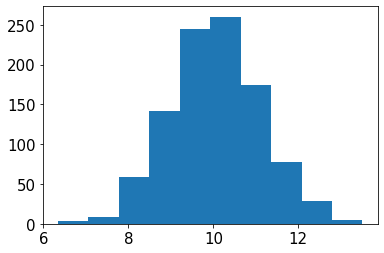

In [745]:
plt.hist(generate_truncnormal(1000, 10, 1, 5, 15))

In [746]:
def generate_two_truncnormal(size, a, mu_1, sigma_1, mu_2, sigma_2, lower, upper):
    samples = np.zeros(size)
    rands = np.random.rand(size)
    for i in range(size):
        if rands[i] < a:
            samples[i] = generate_truncnormal(1, mu_1, sigma_1, lower, upper)
        else:
            samples[i] = generate_truncnormal(1, mu_2, sigma_2, lower, upper)
    return samples

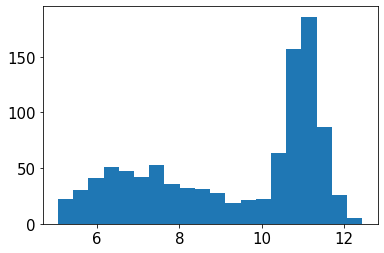

In [747]:
ax = plt.hist(generate_two_truncnormal(1000, 0.5, 7, 2, 11, 0.4, 5, 15), bins=20)

In [748]:
def two_truncnormal_like(x, a, mu_1, sigma_1, mu_2, sigma_2, lower, upper):
    #return st.truncnorm.pdf(x, a=-mu/sigma, b=100, loc = mu, scale = sigma)
    result = np.zeros(x.shape[0])
    result[np.logical_and(x<=upper, x>=lower)] = a*phi(x[np.logical_and(x<=upper, x>=lower)],mu_1,sigma_1)/(normal_cdf(upper,mu_1,sigma_1)-normal_cdf(lower,mu_1,sigma_1))+(1-a)*phi(x[np.logical_and(x<=upper, x>=lower)],mu_2,sigma_2)/(normal_cdf(upper,mu_2,sigma_2)-normal_cdf(lower,mu_2,sigma_2))
    result[np.logical_or(x>upper, x<lower)] = 0
    return result

In [1218]:
def two_truncnormal_like_one(x, a, mu_1, sigma_1, mu_2, sigma_2, lower, upper):
    #return st.truncnorm.pdf(x, a=-mu/sigma, b=100, loc = mu, scale = sigma)
    if x<= upper and x>= lower:
        return a*phi(x,mu_1,sigma_1)/(normal_cdf(upper,mu_1,sigma_1)-normal_cdf(lower,mu_1,sigma_1))+(1-a)*phi(x,mu_2,sigma_2)/(normal_cdf(upper,mu_2,sigma_2)-normal_cdf(lower,mu_2,sigma_2))
    return 0

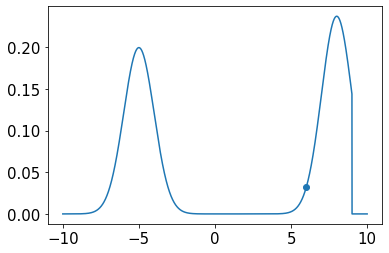

In [1224]:
x = np.linspace(-10, 10, 10000)
plt.plot(x, two_truncnormal_like(x, 0.5, -5, 1, 8, 1, -10, 9))
plt.scatter(6, two_truncnormal_like_one(6, 0.5, -5, 1, 8, 1, -10, 9))

In [751]:
np.trapz(two_truncnormal_like(x, 0.5, -5, 1, 8, 1, -10, 9), x)

1.0001293986497852

In [752]:
def m_crit(m_TOV, j_jkep):
    a2 = 1.316e-1
    a4 = 7.111e-2
    return (1 + a2*(j_jkep)**2 + a4*(j_jkep)**4)*m_TOV

In [756]:
def spin_mass_samples_one(N, m_TOV, mu_1, sigma_1, max_jjkep=1):
    # no preference for q (each partner is independent)
    # default minimum mass = 1
    N = N*2
    samples = np.zeros(N)
    spins = np.random.rand(N) * max_jjkep
    for i in range(N):
        samples[i] = float(generate_truncnormal(1, mu_1, sigma_1, lower=1, upper=m_crit(m_TOV, spins[i])))
    return samples, spins

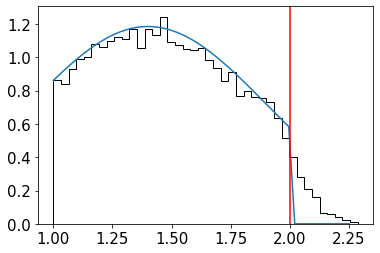

In [755]:
ax = plt.hist(spin_mass_samples_one(10000, 2, 1.4, 0.5, 0.9), bins=40, density=True, histtype='step', color='k')
xs = np.linspace(1, 2.25)
plt.plot(xs, truncnormal_like(xs, 1.4, 0.5, 1, 2))
plt.axvline(2, c='r')

In [757]:
def event_spin_samples_one_like(x, params, spin=0, max_jjkep=1):
    # params = mu, sigma, m_TOV
    #spins = np.linspace(0, max_jjkep, 100)
    #truncs = [truncnormal_like_one(x, params[0], params[1], 1, m_crit(params[2], i)) for i in spins]
    return truncnormal_like_one(x, params[0], params[1], 1, m_crit(params[2], spin))

In [758]:

def event_spin_samples_one_like_nospin(x, params, max_jjkep=1):
    # params = mu, sigma, m_TOV 
    return truncnormal_like_one(x, params[0], params[1], 1, params[2])

def pop_spin_samples_one_like_nospin(x, params, max_jjkep=1):
    
    return np.sum([np.log(event_spin_samples_one_like_nospin(i, params, max_jjkep)) for i in x])

In [759]:
def event_spin_samples_one_like(x, params, spin=0, max_jjkep=1):
    # params = mu, sigma, m_TOV
    #spins = np.linspace(0, max_jjkep, 100)
    #truncs = [truncnormal_like_one(x, params[0], params[1], 1, m_crit(params[2], i)) for i in spins]
    return truncnormal_like_one(x, params[0], params[1], 1, m_crit(params[2], spin))

def pop_spin_samples_one_like(x, spin, params, max_jjkep=1):
    #print(x)
    return np.sum([np.log(event_spin_samples_one_like(x[i], params, spin[i], max_jjkep)) for i in range(len(x))])

In [760]:
def loglike_one(params, data):
    return pop_spin_samples_one_like_nospin(data, params)


def logpost_one(params, data):
    if params[0] > np.min(data) and params[0] < np.max(data):
        if params[1] < 1 and params[1] > 0.01:
            if params[2] > 1.5 and params[2] < 2.5:
                return loglike_one(params, data)
    return -np.inf

In [761]:
test_data, spins = spin_mass_samples_one(10, 2, 1.4, 0.5, 0)
p0 = [1.4, 0.5, 2]
pscale = [0.1, 0.05, 0.1]
pos = p0 + pscale*np.random.randn(6, 3)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=([test_data]))
sampler.run_mcmc(pos, 5000, progress=True)
samples = sampler.get_chain(discard = 100, flat=True)

In [ ]:
corner.corner(samples, truths=[1.4, 0.5, 2], truth_color='red', labels=['$\mu$', '$\sigma$', '$M_{TOV}$'])

In [762]:
def loglike_one(params, data, spins):
    return pop_spin_samples_one_like(data, spins, params)

def logpost_one(params, data, spins):
    if params[0] > np.min(data) and params[0] < np.max(data):
        if params[1] < 1 and params[1] > 0.01:
            if params[2] > 1.5 and params[2] < 2.5:
                return loglike_one(params, data, spins)
    return -np.inf

In [763]:
test_data, spins = spin_mass_samples_one(50, 2, 1.4, 0.5, 1)
p0 = [1.4, 0.5, 2]
pscale = [0.1, 0.05, 0.1]
pos = p0 + pscale*np.random.randn(6, 3)
nwalkers, ndim = pos.shape

In [764]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=(test_data, spins))
sampler.run_mcmc(pos, 10000, progress=True)
samples = sampler.get_chain(discard = 100, flat=True)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
  0%|          | 0/10000 [00:00<?, ?it/s]/root/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [02:55<00:00, 56.88it/s]


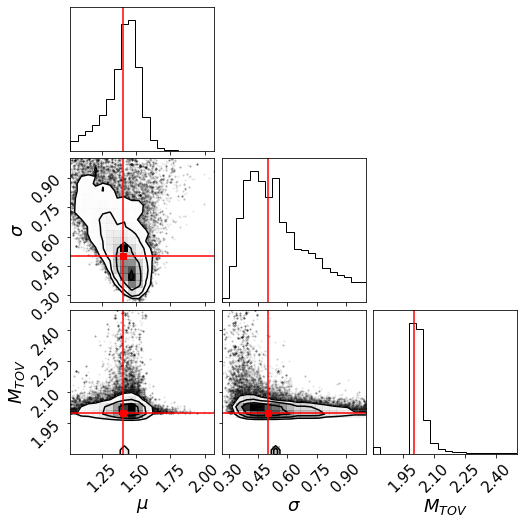

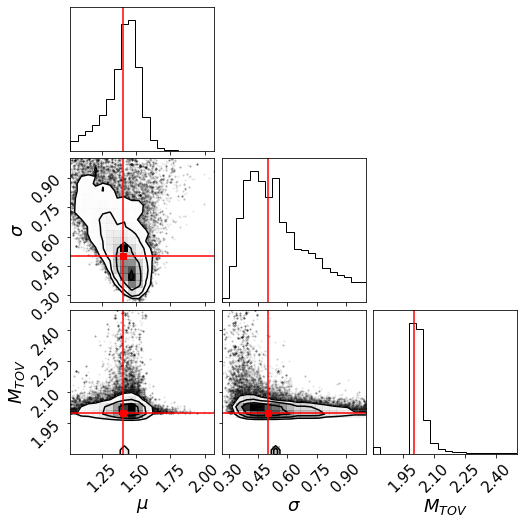

In [765]:
corner.corner(samples, truths=[1.4, 0.5, 2], truth_color='red', labels=['$\mu$', '$\sigma$', '$M_{TOV}$'])

In [1146]:
def spin_mass_samples_two(N, m_TOV, a, mu_1, sigma_1, mu_2, sigma_2, max_jjkep=1):
    # no preference for q (random)
    # default minimum mass = 1
    N = N*2
    samples = np.zeros(N)
    spins = np.random.rand(N) * max_jjkep
    for i in range(N):
        #print(generate_two_truncnormal(1, a, mu_1, sigma_1, mu_2, sigma_2, lower=1, upper=m_crit(m_TOV, spins[i])))
        samples[i] = float(generate_two_truncnormal(1, a, mu_1, sigma_1, mu_2, sigma_2, lower=1, upper=m_crit(m_TOV, spins[i])))
    return samples#, spins

Text(0.5, 1.0, 'Maximum $\\frac{j}{j_{kep}}$ = 1')

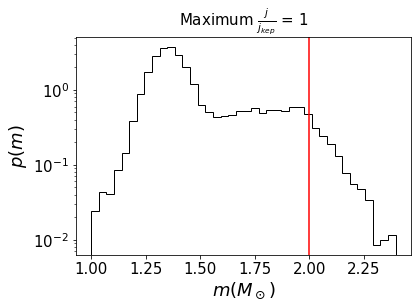

In [768]:
ax = plt.hist(spin_mass_samples_two(10000, 2, 0.63, 1.35, 0.07, 1.85, 0.35), bins=40, density=True, histtype='step', color='k')
plt.axvline(2, c='r')
plt.yscale('log')
plt.ylabel('$p(m)$')
plt.xlabel('$m (M_\odot)$')
plt.title(r'Maximum $\frac{j}{j_{kep}}$ = 1')

Text(0.5, 1.0, 'Maximum $\\frac{j}{j_{kep}}$ = 0.5')

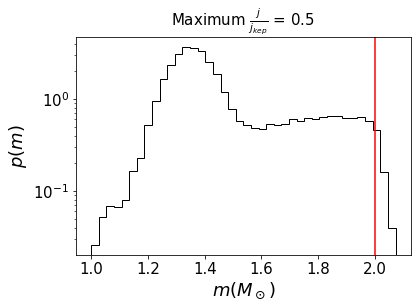

In [769]:
ax = plt.hist(spin_mass_samples_two(10000, 2, 0.63, 1.35, 0.07, 1.85, 0.35, 0.5), bins=40, density=True, histtype='step', color='k')
plt.axvline(2, c='r')
plt.yscale('log')
plt.ylabel('$p(m)$')
plt.xlabel('$m (M_\odot)$')
plt.title(r'Maximum $\frac{j}{j_{kep}}$ = 0.5')

In [787]:
def like_m2(m_2, m_1, m_min=1, beta=3):
    like = m_2**beta * (beta+1)
    like /= (m_1**(beta+1)-m_min**(beta+1))
    return like

In [771]:
def generate_q(N, beta):
    draws = np.random.rand(N*100, 2)
    draws = draws[draws[:, 1] < draws[:,0]**beta]
    return draws[:N, 0]

In [772]:
def generate_q(N, beta, m_1, m_min = 1):
    draws = np.random.rand(N*100, 2)
    draws = draws * ((m_1**(beta+1))-(m_min**(beta+1))) # first scale to within (0,1)
    draws += m_min**(beta+1) # then shift so m_min is 0
    draws = draws**(1/(beta+1)) # then complete inverse transform
    return draws[:N, 0]

In [773]:
def testcdf(x, beta, m_1, m_min):
    return x**(beta+1)/((2**(beta+1)-1**(beta+1)))

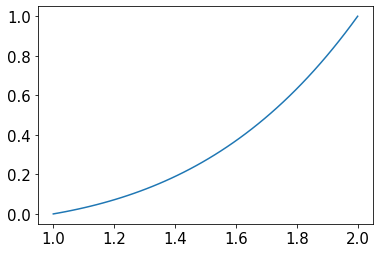

In [774]:
x = np.linspace(1, 2, 50)
plt.plot(x, testcdf(x, 3, 2, 1)-testcdf(1,3,2,1))

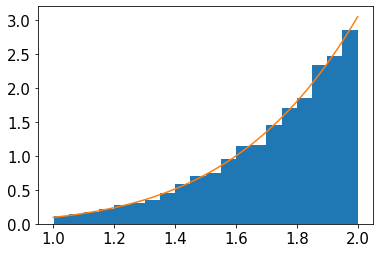

In [790]:
plt.hist(generate_q(10000, 5, 1, 2), bins=20, density=True)
xs = np.linspace(1.0, 2.0)
plt.plot(xs,like_m2(xs, 2, 1, 5))

In [791]:
np.trapz(like_m2(xs, 2, 1, 5), xs)

1.0002479084459537

In [792]:
def spin_mass_samples_two_q(N, m_TOV, a, mu_1, sigma_1, mu_2, sigma_2, max_jjkep=1, beta=3):
    # uniformly distributed in q between 0.5 and 1
    # default minimum mass = 1
    N_ns = N*2
    samples = np.zeros(N_ns)
    spins = np.random.rand(N_ns) * max_jjkep
    for i in range(N):
        #print(generate_two_truncnormal(1, a, mu_1, sigma_1, mu_2, sigma_2, lower=1, upper=m_crit(m_TOV, spins[i])))
        samples[i] = float(generate_two_truncnormal(1, a, mu_1, sigma_1, mu_2, sigma_2, lower=1, upper=m_crit(m_TOV, spins[i])))
    for i in range(N):
        samples[i+N] = generate_q(1, beta, np.min([samples[i], m_crit(m_TOV, spins[i+N])]), 1)
    return samples

Text(0.5, 1.0, '$p(q) \\propto q^3$, Maximum $\\frac{j}{j_{kep}}$ = 1')

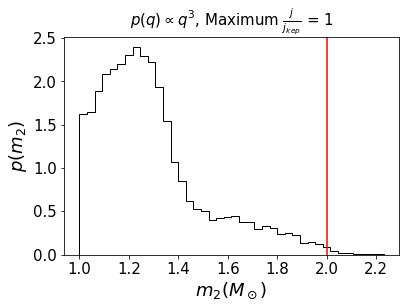

In [793]:
ax = plt.hist(spin_mass_samples_two_q(10000, 2, 0.63, 1.35, 0.07, 1.85, 0.35, 1)[10000:], bins=40, density=True, histtype='step', color='k')
plt.axvline(2, c='r')
#plt.yscale('log')
plt.ylabel('$p(m_2)$')
plt.xlabel('$m_2 (M_\odot)$')
plt.title(r'$p(q) \propto q^3$, Maximum $\frac{j}{j_{kep}}$ = 1') 

# what do i do about the tail?

Text(0.5, 1.0, '$p(q) \\propto q^3$, Maximum $\\frac{j}{j_{kep}}$ = 1')

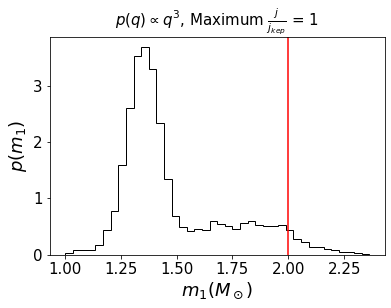

In [794]:
ax = plt.hist(spin_mass_samples_two_q(10000, 2, 0.63, 1.35, 0.07, 1.85, 0.35, 1)[:10000], bins=40, density=True, histtype='step', color='k')
plt.axvline(2, c='r')
#plt.yscale('log')
plt.ylabel('$p(m_1)$')
plt.xlabel('$m_1(M_\odot)$')
plt.title(r'$p(q) \propto q^3$, Maximum $\frac{j}{j_{kep}}$ = 1')

Text(0, 0.5, 'q')

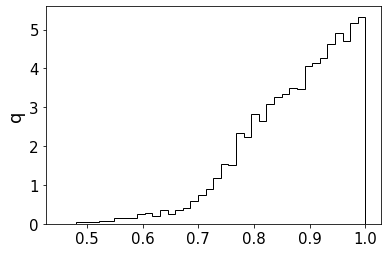

In [795]:
data = spin_mass_samples_two_q(10000, 2, 0.63, 1.35, 0.07, 1.85, 0.35, 1)
plt.hist(data[10000:]/data[:10000], bins=40, density=True, histtype='step', color='k')
x = np.linspace(0,1,50)
plt.ylabel('q')

In [796]:
def get_rho(N, index=4, rhomin = 10):
    r = np.random.rand(N)
    return rhomin * (1-r) ** (-1/(index-1))

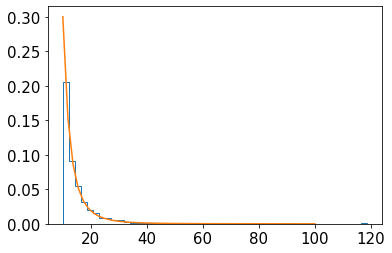

In [797]:
plt.hist(get_rho(1000), histtype='step', density=True, bins=50)
x = np.linspace(10, 100)
plt.plot(x, 3000*x**-4)

In [798]:
import math
math.pi

3.141592653589793

In [799]:
def get_psi(m_1, m_2, chieff):
    m_chirp = (m_1*m_2)**(3/5)/((m_1+m_2)**(1/5))
    q=m_2/m_1
    v=q/((1+q)**2)
    dm = (m_1-m_2)/(m_1+m_2)
    
    psi_0 = 3/(128*m_chirp**(5/3)*math.pi**(5/3))
    psi_2 = 5/(96*m_chirp*math.pi*v**(2/5))
    psi_2 *= ((743/336)+(11*v/4)) 
    beta = (1/3)*(((113-76*v)/4)*chieff) # neglecting + (76/4)*dm*v*chia
    psi_3 = 3*(4*beta-16*math.pi)/(128*m_chirp**(2/3)*math.pi**(2/3)*v**(3/5))
    
    return [psi_0, psi_2, psi_3]

In [ ]:
get_psi(1, 2, 0)

In [ ]:
def draw_psi(N, psi, snr=10):
    sigma0 = 0.0046*psi[0]/snr
    sigma2 = 0.2341*psi[1]/snr
    sigma3 = -0.1293*psi[2]/snr
    
    return np.array([np.random.randn(N)*sigma0+psi[0], np.random.randn(N)*sigma2+psi[1], np.random.randn(N)*sigma3+psi[2]])

In [ ]:
draws = draw_psi(100000, get_psi(1,2,0),10)

In [800]:
def chirp_mass(m_1, m_2):
    return (m_1*m_2)**(3/5)/((m_1+m_2)**(1/5))

In [801]:
def chirp_mass_sigma(m_1, m_2, rho=10):
    alpha = 0
    v = mass_ratio(m_1, m_2)
    
    if v > 0.1:
        alpha = 0.01
    elif v < 0.1 and v > 0.05:
        alpha = 0.03
    elif v < 0.05:
        alpha = 0.1
    
    return chirp_mass(m_1, m_2)*alpha*12/rho

In [802]:
def mass_ratio(m_1, m_2):
    q=m_2/m_1
    v=q/((1+q)**2)
    return v

In [803]:
def mass_ratio_sigma(m_1, m_2,rho=10):
    return mass_ratio(m_1, m_2)*0.03*12/rho

In [804]:
# from https://arxiv.org/pdf/1711.09226.pdf LALInference simulations. does it need to be multipled by actual chieff?

def chieff_sigma(rho):
    return 0.0086 * ((rho/15)**(-0.41))

In [805]:
# assuming perfectly aligned
def chieff(m_1, m_2, chi_1, chi_2):
    val = m_1 * chi_1 + m_2 * chi_2
    val /= (m_1 + m_2)
    return val

In [806]:
import scipy.stats as st

In [807]:
def jacobian(m_1, m_2):
    jac = m_1**(8/5) * m_2**(8/5)
    jac *= (m_1*m_2-1)
    jac /= (m_1 + m_2)**(21/5)
    return jac

In [808]:
def jacobian(m_1, m_2):
    pa = m_1**(13/5) * m_2**(3/5)
    pa /= (m_1 + m_2)**(21/5)
    
    pb = m_1**(8/5) * m_2**(8/5)
    pb /= (m_1 + m_2)**(21/5)
    
    return pa - pb

In [809]:
def loglike_one(params, m_chirp, m_chirp_sigma, m_ratio, m_ratio_sigma, chi_eff, chi_eff_sigma):
    # params: m_1, m_2, chi_1, chi_2
    like_mchirp = st.norm.pdf(chirp_mass(params[0], params[1]), loc=m_chirp, scale=m_chirp_sigma)
    like_ratio = st.norm.pdf(mass_ratio(params[0], params[1]), loc=m_ratio, scale=m_ratio_sigma)
    like_chieff = st.norm.pdf(chieff(params[0], params[1], params[2], params[3]), loc=chi_eff, scale=chi_eff_sigma)
    return np.log(like_mchirp) + np.log(like_ratio) + np.log(like_chieff) + np.log(jacobian(params[0], params[1]))


def logpost_one(params, m_chirp, m_chirp_sigma, mass_ratio, mass_ratio_sigma, chi_eff, chi_eff_sigma):
    if params[0] > 0.5 and params[0] < 3.5:
        if params[1] > 0.5 and params[1] < 3.5:
            if params[0] > params[1]:
                if params[2] > 0 and params[2] < 1:
                    if params[3] > 0 and params[3] < 1:
                        loglike = loglike_one(params, m_chirp, m_chirp_sigma, mass_ratio, mass_ratio_sigma, chi_eff, chi_eff_sigma)
                        return loglike
    return -np.inf

In [810]:
logpost_one([2.1439731 , 1.50150052, 0.25678303, 0.19066567], test_mchirp, test_mchirp_sigma, test_ratio, test_ratio_sigma, test_chieff, test_chieff_sigma)

-79.44063600172227

In [818]:
test_m_1 = 2
test_m_2 = 1.5
test_chi_1 = 0.1
test_chi_2 = 0.1
test_rho = 10

test_mchirp = chirp_mass(test_m_1, test_m_2)
test_mchirp_sigma = chirp_mass_sigma(test_m_1, test_m_2, test_rho)
test_mchirp += float(np.random.randn()*test_mchirp_sigma)

    
test_ratio = mass_ratio(test_m_1, test_m_2)
test_ratio_sigma = float(mass_ratio_sigma(test_m_1, test_m_2,test_rho))
test_ratio += float(np.random.randn()*test_ratio_sigma)

test_chieff = chieff(test_m_1, test_m_2, test_chi_1, test_chi_2)
test_chieff_sigma = float(chieff_sigma(test_rho))
test_chieff += float(np.random.randn()*test_chieff_sigma)

In [819]:
p0 = [2, 1.5, 0.1, 0.1]
pscale = [0.1, 0.1, 0.1, 0.1]
pos = p0 + pscale*np.random.randn(8, 4)
p0 = np.abs(p0)
nwalkers, ndim = pos.shape

In [820]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=(test_mchirp, test_mchirp_sigma, test_ratio, test_ratio_sigma, test_chieff, test_chieff_sigma))
sampler.run_mcmc(pos, 5000, progress=True)
samples = sampler.get_chain(discard = 100, flat=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/root/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:23<00:00, 215.53it/s]


In [821]:
samples = sampler.get_chain(flat=True)

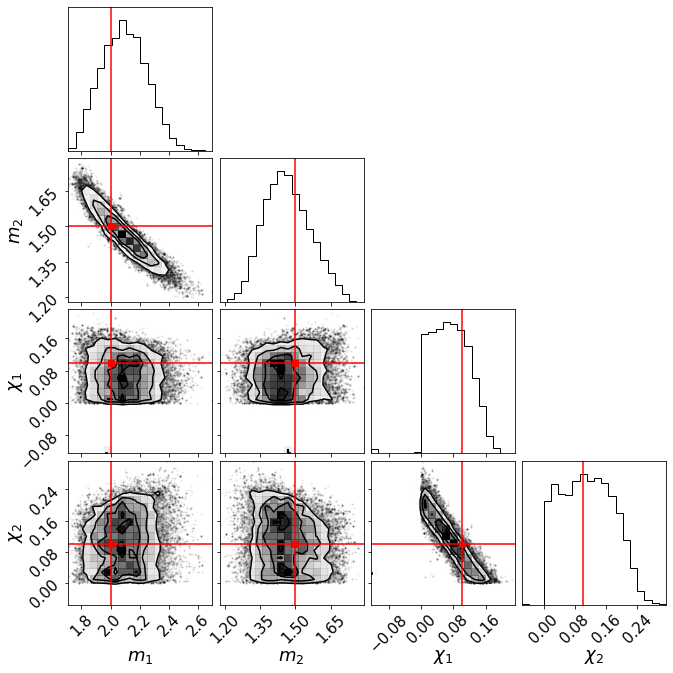

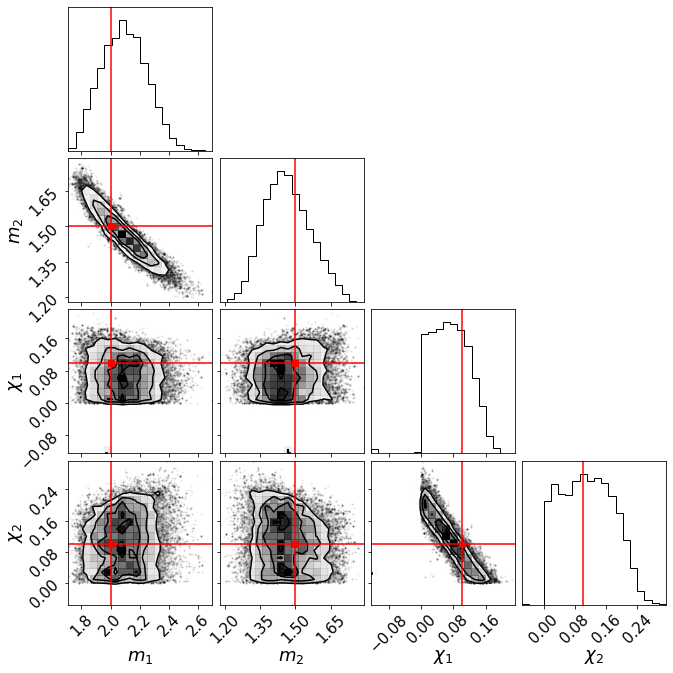

In [822]:
corner.corner(samples, truths=p0, truth_color='red', labels=['$m_1$', '$m_2$', '$\chi_1$', '$\chi_2$'])

In [1305]:
def get_samples_mcmc(m_TOV, mu_1, sigma_1, max_jjkep=1, beta=4, n=2000, thin=1, return_p0=False):
    test_chi_1 = np.random.rand() * max_jjkep
    #print(max_jjkep)
    test_chi_2 = np.random.rand() * max_jjkep
    test_m_1 = float(generate_truncnormal(1, mu_1, sigma_1, lower=1, upper=m_crit(m_TOV, test_chi_1)))
    test_m_2 = float(generate_q(1, beta, np.min([test_m_1, m_crit(m_TOV, test_chi_2)]), 1))
    test_rho = get_rho(1, 4, 10)

    test_mchirp = chirp_mass(test_m_1, test_m_2)
    test_mchirp_sigma = float(chirp_mass_sigma(test_m_1, test_m_2, test_rho))
    test_mchirp += float(np.random.randn()*test_mchirp_sigma)

    
    test_ratio = mass_ratio(test_m_1, test_m_2)
    test_ratio_sigma = float(mass_ratio_sigma(test_m_1, test_m_2,test_rho))
    test_ratio += float(np.random.randn()*test_ratio_sigma)
    
    test_chieff = chieff(test_m_1, test_m_2, test_chi_1, test_chi_2)
    test_chieff_sigma = float(chieff_sigma(test_rho))
    test_chieff += float(np.random.randn()*test_chieff_sigma)
    
    p0 = [test_m_1, test_m_2, test_chi_1, test_chi_2]
    pscale = [0.1, 0.1, 0.1, 0.1]
    pos = p0 + pscale*np.random.randn(8, 4)
    pos = np.abs(pos)
    nwalkers, ndim = pos.shape
    
    def loglike_one(params, m_chirp, m_chirp_sigma, m_ratio, m_ratio_sigma, chi_eff, chi_eff_sigma):
        #print(params)
        # params: m_1, m_2, chi_1, chi_2
        like_mchirp = st.norm.pdf(chirp_mass(params[0], params[1]), loc=m_chirp, scale=m_chirp_sigma)
        like_ratio = st.norm.pdf(mass_ratio(params[0], params[1]), loc=m_ratio, scale=m_ratio_sigma)
        like_chieff = st.norm.pdf(chieff(params[0], params[1], params[2], params[3]), loc=chi_eff, scale=chi_eff_sigma)
        return np.log(like_mchirp) + np.log(like_ratio) + np.log(like_chieff)


    def logpost_one(params, m_chirp, m_chirp_sigma, mass_ratio, mass_ratio_sigma, chi_eff, chi_eff_sigma):
        if params[0] > 0.5 and params[0] < 3.5:
            if params[1] > 0.5 and params[1] < 3.5:
                if params[0] > params[1]:
                    if params[2] > 0 and params[2] < 1:
                        if params[3] > 0 and params[3] < 1:
                            loglike = loglike_one(params, m_chirp, m_chirp_sigma, mass_ratio, mass_ratio_sigma, chi_eff, chi_eff_sigma)
                            return loglike
        return -np.inf
    
    #print(p0)
    if return_p0:
        #print(p0)
        return p0
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=(test_mchirp, test_mchirp_sigma, test_ratio, test_ratio_sigma, test_chieff, test_chieff_sigma))
    sampler.run_mcmc(pos, n, progress=False)
    #t_auto = np.mean(sampler.get_autocorr_time())
    samples = sampler.get_chain(discard = int(n/4), flat=True, thin=thin)
    
    return samples

In [1306]:
def spin_mass_samples_one_mcmc(N, m_TOV, mu_1, sigma_1, max_jjkep=1, n=10000, thin=1, return_p0=False):
    # no preference for q (each partner is independent)
    # default minimum mass = 1
    # N = number of binaries
    if return_p0:
        samples = np.zeros((N, 1, 4))#
    else:
        samples = np.zeros((N, int((n*0.75)*8/thin), 4))#
    for i in range(N):
        samples[i] = get_samples_mcmc(m_TOV, mu_1, sigma_1, n=n, max_jjkep=max_jjkep, thin=thin, return_p0=return_p0)
    return samples

In [1307]:
def event_spin_mcmc_one_like(samples, params):
    # params = mu, sigma, m_TOV
    #print(samples.shape)
    
    # truncated normal likelihood depends on params (mu, sigma, m_TOV) and specific sample (spin)
    truncs = np.array([truncnormal_like_one(i[0], params[0], params[1], lower = 1, upper = m_crit(params[2], i[2])) \
                       for i in samples])
    
    # qlikes depends on params (min & max mass) and specific sample
    qlikes = np.array([like_m2(i[1], min([i[0], m_crit(params[2], i[3])])) for i in samples])
    # could also have spin likes
    return np.mean(truncs*qlikes)

def pop_spin_mcmc_one_like(samples, params):
    #print(x)
    result = np.sum([np.log(event_spin_mcmc_one_like(i, params)) for i in samples])
    if math.isnan(result):
        return -np.inf
    return result

In [1369]:
def event_spin_mcmc_one_like_speed(samples, params):
    # params = mu, sigma, m_TOV
    #print(samples.shape)
    
    # truncated normal likelihood depends on params (mu, sigma, m_TOV) and specific sample (spin)
    truncs = truncnormal_like(samples[:,0], params[0], params[1], lower = 1, upper = m_crit(params[2], samples[:,2])) 
    
    # qlikes depends on params (min & max mass) and specific sample
    qlikes = like_m2(samples[:,1], np.min([samples[:,0], m_crit(params[2], samples[:,3])], axis=0)) 
    # could also have spin likes
    return np.mean(truncs*qlikes)

In [1367]:
event_spin_mcmc_one_like(test[0], [1.4, 0.5, 2.0, 0.5])

2.663865005605171

In [1370]:
event_spin_mcmc_one_like_speed(test[0], [1.4, 0.5, 2.0, 0.5])

2.663865005605171

In [1088]:
pop_spin_mcmc_one_like(test, [1.4, 0.5, 2.0, 0.5])

2.4018284484868477

In [1021]:
test = spin_mass_samples_one_mcmc(5,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=0.7, n=3000, thin=10)

In [1022]:
pop_spin_mcmc_one_like(test, [1.4, 0.5, 2])

5.642620384189947

In [1303]:
def loglike_one(params, data):
    return pop_spin_mcmc_one_like(data, params)

def logpost_one(params, data):
    if params[0] > 1 and params[0] < 2:
        if params[1] < 1 and params[1] > 0.01:
            if params[2] > 1.5 and params[2] < 2.5:
                if params[3] > 0.5 and params[3] < 1.5:
                    return loglike_one(params, data)
    return -np.inf

In [1304]:


p0 = [1.4, 0.5, 2.1]
pscale = [0.1, 0.05, 0.1]

pos = p0 + pscale*np.random.randn(6, 3)
nwalkers, ndim = pos.shape

In [975]:
#filename = "onepeaked_withspin.h5"
#backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=([test]))
sampler.run_mcmc(pos, 5000, progress=True)
samples = sampler.get_chain(discard = 100, flat=True)
log_prob_samples = sampler.get_log_prob(discard = 100, flat=True)

  0%|          | 16/5000 [00:35<2:56:10,  2.12s/it]/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
  2%|▏         | 120/5000 [03:22<2:39:18,  1.96s/it]/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
  7%|▋         | 355/5000 [09:34<3:12:16,  2.48s/it]/root/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 5000/5000 [2:14:10<00:00,  1.61s/it]  


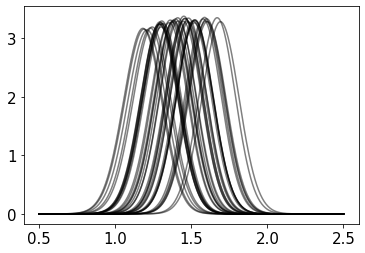

In [1138]:
ps = []
for i in range(40):
    test = spin_mass_samples_one_mcmc(50,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1, p0=True)
    #print(test)
    means = np.linspace(0.5, 2.5, 500)
    probs = np.zeros(500)
    for j in range(500):
        probs[j] = loglike_one([means[j], 0.5, 2], test)
    
    #print(probs)
    greaters = means[means>1.4]
    ps.append(np.trapz(np.exp(probs[means>1.4]), greaters)/np.trapz(np.exp(probs), means))
    plt.plot(means, np.exp(probs)/np.trapz(np.exp(probs), means), c='k', alpha=0.5)

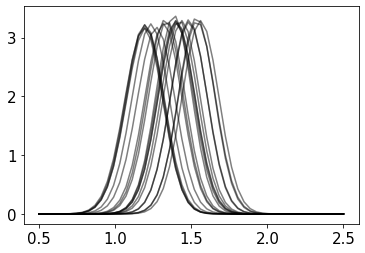

In [1063]:
for i in range(20):
    test = spin_mass_samples_one_mcmc(50,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1)
    #sigmas = np.linspace(0.1, 1, 50)
    means = np.linspace(0.5, 2.5, 50)
    probs = np.zeros(50)
    for j in range(50):
        probs[j] = loglike_one([means[j], 0.5, 2], test)
    
    #print(probs)
    
    plt.plot(means, np.exp(probs)/np.trapz(np.exp(probs), means), c='k', alpha=0.5)

In [ ]:
ps = []
for i in range(400):
    test = spin_mass_samples_one_mcmc(50,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1, p0=True)
    sigmas = np.linspace(0.1, 1, 50)
    #means = np.linspace(0.5, 2.5, 50)
    probs = np.zeros(50)
    for j in range(50):
        probs[j] = loglike_one([1.4, sigmas[j], 2], test)
    
    #print(probs)
    greaters = sigmas[sigmas>0.5]
    ps.append(np.trapz(np.exp(probs[sigmas>0.5]), greaters)/np.trapz(np.exp(probs), sigmas))
    plt.axvline(0.5)
    plt.plot(sigmas, np.exp(probs)/np.trapz(np.exp(probs), sigmas), c='k', alpha=0.5)

In [ ]:
plt.hist(ps)

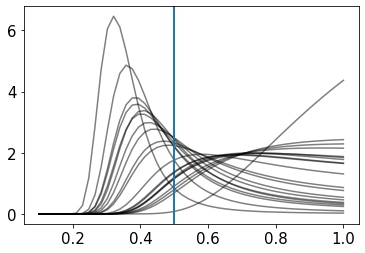

In [1064]:
for i in range(20):
    test = spin_mass_samples_one_mcmc(50,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1)
    sigmas = np.linspace(0.1, 1, 50)
    #means = np.linspace(0.5, 2.5, 50)
    probs = np.zeros(50)
    for j in range(50):
        probs[j] = loglike_one([1.4, sigmas[j], 2], test)
    
    #print(probs)
    plt.axvline(0.5)
    plt.plot(sigmas, np.exp(probs)/np.trapz(np.exp(probs), sigmas), c='k', alpha=0.5)

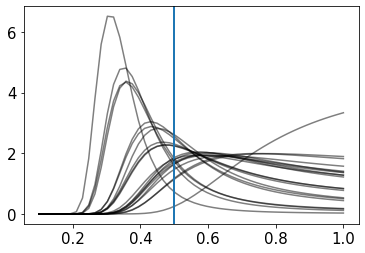

In [1073]:
for i in range(20):
    test = spin_mass_samples_one_mcmc(50,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1, p0=False)
    sigmas = np.linspace(0.1, 1, 50)
    #means = np.linspace(0.5, 2.5, 50)
    probs = np.zeros(50)
    for j in range(50):
        probs[j] = loglike_one([1.4, sigmas[j], 2], test)
    
    #print(probs)
    plt.axvline(0.5)
    plt.plot(sigmas, np.exp(probs)/np.trapz(np.exp(probs), sigmas), c='k', alpha=0.5)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/root/anaconda3/lib/python3.7/site

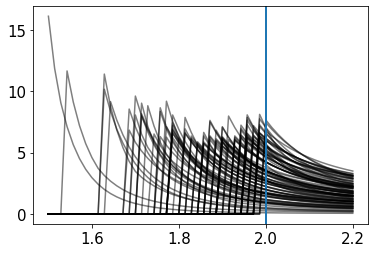

In [1121]:
ps = []
for i in range(100):
    test = spin_mass_samples_one_mcmc(10,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1, p0=True)
    #sigmas = np.linspace(0.1, 1, 50)
    #means = np.linspace(0.5, 2.5, 50)
    mTOVs = np.linspace(1.5, 2.2, 50)
    probs = np.zeros(50)
    for j in range(50):
        probs[j] = loglike_one([1.4, 0.5, mTOVs[j]], test)
    
    #print(probs)
    lowers = mTOVs[mTOVs >= 2.0]
    ps.append(np.trapz(np.exp(probs[mTOVs>=2.0]), lowers)/np.trapz(np.exp(probs), mTOVs))
    plt.axvline(2.0)
    plt.plot(mTOVs, np.exp(probs)/np.trapz(np.exp(probs), mTOVs), c='k', alpha=0.5)

In [1287]:
test = spin_mass_samples_one_mcmc(10,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1, p0=False)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: Runtim

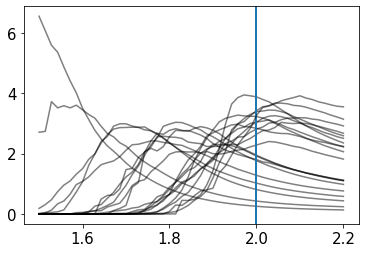

In [1308]:
for i in range(20):
    test = spin_mass_samples_one_mcmc(10,m_TOV=2,mu_1=1.4,sigma_1=0.5, max_jjkep=1.0, n=500, thin=1, return_p0=False)
    #sigmas = np.linspace(0.1, 1, 50)
    #means = np.linspace(0.5, 2.5, 50)
    mTOVs = np.linspace(1.5, 2.2, 50)
    probs = np.zeros(50)
    for j in range(50):
        probs[j] = loglike_one([1.4, 0.5, mTOVs[j]], test)
    
    #print(probs)
    plt.axvline(2.0)
    plt.plot(mTOVs, np.exp(probs)/np.trapz(np.exp(probs), mTOVs), c='k', alpha=0.5)

In [993]:
np.trapz(np.exp(probs), means)

4.416978376555499

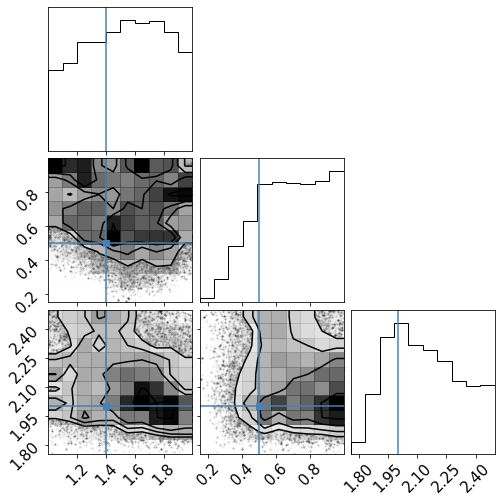

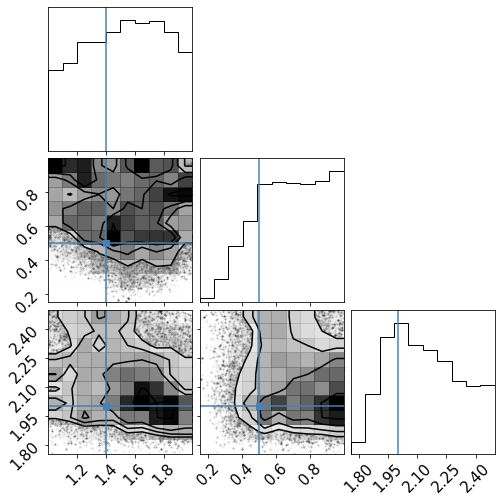

In [978]:
corner.corner(samples, bins=10, truths=[1.4, 0.5, 2.0] )

In [979]:
np.savetxt('./5event_chain.txt', samples)

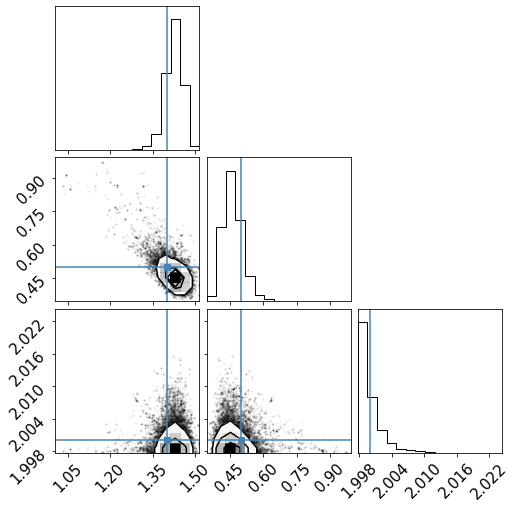

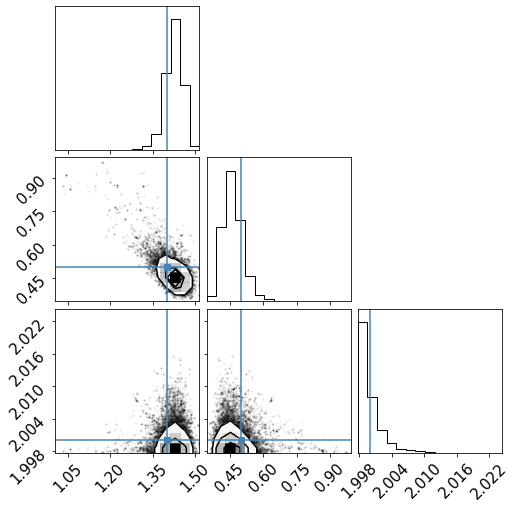

In [938]:
corner.corner(samples, bins=15, truths=[1.4, 0.5, 2.0] )

In [1140]:
chirps = np.zeros((150,150))
etas = np.zeros((150,150))
m1 = np.linspace(0.5, 5, 150)
m2 = np.linspace(0.5, 5, 150)
for i in range(150):
    for j in range(150):
        if m1[i]>m2[j]:
            chirps[i,j]=chirp_mass(m1[i], m2[j])
            etas[i,j] =mass_ratio(m1[i], m2[j])

In [1141]:
samples = np.random.rand(100000,2)*[5,5]+[0.5, 0.5]

In [1142]:
chirps = chirp_mass(samples[:,0], samples[:,1])

In [1143]:
etas = mass_ratio(samples[:,0], samples[:,1])

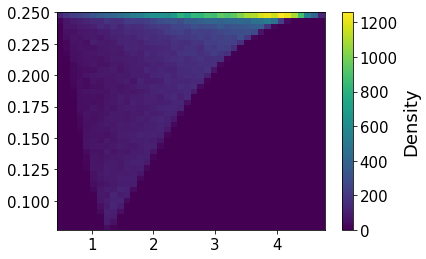

In [1144]:
plt.hist2d(chirps, etas, bins=40)
plt.colorbar(label="Density")

# how much space in m_1, m_2 does chirp mass and eta this map to?

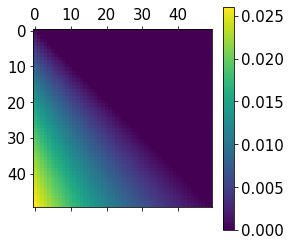

In [1145]:
jacs = np.zeros((50,50))
m1 = np.linspace(1, 2.5, 100)
m2 = np.linspace(1, 2.5, 100)
for i in range(50):
    for j in range(50):
        if m1[i]>m2[j]:
            jacs[i,j]=jacobian(m1[i], m2[j])
            
plt.matshow(jacs)
plt.colorbar()

Text(0.5, 1.0, 'Maximum $\\frac{j}{j_{kep}}$ = 1')

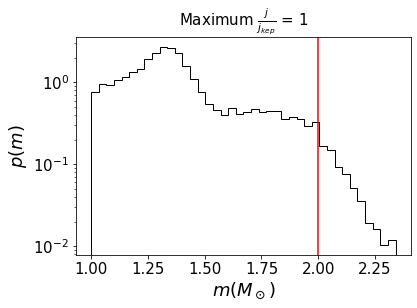

In [1148]:
ax = plt.hist(spin_mass_samples_two_q(10000, 2, 0.63, 1.35, 0.07, 1.85, 0.35), bins=40, density=True, histtype='step', color='k')
plt.axvline(2, c='r')
plt.yscale('log')
plt.ylabel('$p(m)$')
plt.xlabel('$m (M_\odot)$')
plt.title(r'Maximum $\frac{j}{j_{kep}}$ = 1')

In [ ]:
def spin_mass_samples_two_q(N, m_TOV, a, mu_1, sigma_1, mu_2, sigma_2, max_jjkep=1, beta=3):
    # uniformly distributed in q between 0.5 and 1
    # default minimum mass = 1
    N_ns = N*2
    samples = np.zeros(N_ns)
    spins = np.random.rand(N_ns) * max_jjkep
    for i in range(N):
        #print(generate_two_truncnormal(1, a, mu_1, sigma_1, mu_2, sigma_2, lower=1, upper=m_crit(m_TOV, spins[i])))
        samples[i] = float(generate_two_truncnormal(1, a, mu_1, sigma_1, mu_2, sigma_2, lower=1, upper=m_crit(m_TOV, spins[i])))
    for i in range(N):
        samples[i+N] = generate_q(1, beta, np.min([samples[i], m_crit(m_TOV, spins[i+N])]), 1)
    return samples

In [1296]:
def get_samples_mcmc_twocomponent(m_TOV,a, mu_1, sigma_1, mu_2, sigma_2, max_jjkep=1, beta=4, n=2000, thin=1, return_p0=False):
    #print(return_p0)
    test_chi_1 = np.random.rand() * max_jjkep
    #print(max_jjkep)
    test_chi_2 = np.random.rand() * max_jjkep
    test_m_1 = float(generate_two_truncnormal(1, a, mu_1, sigma_1, mu_2, sigma_2, lower=1, upper=m_crit(m_TOV, test_chi_1)))
    test_m_2 = float(generate_q(1, beta, np.min([test_m_1, m_crit(m_TOV, test_chi_2)]), 1))
    test_rho = get_rho(1, 4, 10)

    test_mchirp = chirp_mass(test_m_1, test_m_2)
    test_mchirp_sigma = float(chirp_mass_sigma(test_m_1, test_m_2, test_rho))
    test_mchirp += float(np.random.randn()*test_mchirp_sigma)

    
    test_ratio = mass_ratio(test_m_1, test_m_2)
    test_ratio_sigma = float(mass_ratio_sigma(test_m_1, test_m_2,test_rho))
    test_ratio += float(np.random.randn()*test_ratio_sigma)
    
    test_chieff = chieff(test_m_1, test_m_2, test_chi_1, test_chi_2)
    test_chieff_sigma = float(chieff_sigma(test_rho))
    test_chieff += float(np.random.randn()*test_chieff_sigma)
    
    p0 = [test_m_1, test_m_2, test_chi_1, test_chi_2]
    pscale = [0.1, 0.1, 0.1, 0.1]
    pos = p0 + pscale*np.random.randn(8, 4)
    pos = np.abs(pos)
    nwalkers, ndim = pos.shape
    
    def loglike_one(params, m_chirp, m_chirp_sigma, m_ratio, m_ratio_sigma, chi_eff, chi_eff_sigma):
        #print(params)
        # params: m_1, m_2, chi_1, chi_2
        like_mchirp = st.norm.pdf(chirp_mass(params[0], params[1]), loc=m_chirp, scale=m_chirp_sigma)
        like_ratio = st.norm.pdf(mass_ratio(params[0], params[1]), loc=m_ratio, scale=m_ratio_sigma)
        like_chieff = st.norm.pdf(chieff(params[0], params[1], params[2], params[3]), loc=chi_eff, scale=chi_eff_sigma)
        return np.log(like_mchirp) + np.log(like_ratio) + np.log(like_chieff)


    def logpost_one(params, m_chirp, m_chirp_sigma, mass_ratio, mass_ratio_sigma, chi_eff, chi_eff_sigma):
        if params[0] > 0.5 and params[0] < 3.5:
            if params[1] > 0.5 and params[1] < 3.5:
                if params[0] > params[1]:
                    if params[2] > 0 and params[2] < 1:
                        if params[3] > 0 and params[3] < 1:
                            loglike = loglike_one(params, m_chirp, m_chirp_sigma, mass_ratio, mass_ratio_sigma, chi_eff, chi_eff_sigma)
                            return loglike
        return -np.inf
    
    #print(p0)
    if return_p0:
        #print('true')
        return p0
    
    #print(p0)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=(test_mchirp, test_mchirp_sigma, test_ratio, test_ratio_sigma, test_chieff, test_chieff_sigma))
    sampler.run_mcmc(pos, n, progress=False)
    #t_auto = np.mean(sampler.get_autocorr_time())
    samples = sampler.get_chain(discard = int(n/4), flat=True, thin=thin)
    
    return samples

In [ ]:
m1 = spin_mass_samples_two_mcmc(1, 2, 0.63, 1.35, 0.07, 1.85, 0.35, max_jjkep=1, return_p0=False)

Text(0.5, 1.0, 'Maximum $\\frac{j}{j_{kep}}$ = 1')

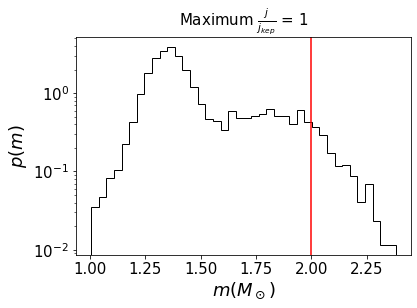

In [1166]:
ax = plt.hist(m1[:,:,0], bins=40, density=True, histtype='step', color='k')

plt.axvline(2, c='r')
plt.yscale('log')
plt.ylabel('$p(m)$')
plt.xlabel('$m (M_\odot)$')
plt.title(r'Maximum $\frac{j}{j_{kep}}$ = 1')

In [1293]:
def spin_mass_samples_two_mcmc(N, m_TOV, a, mu_1, sigma_1, mu_2, sigma_2, max_jjkep=1, n=10000, thin=1, return_p0=True):
    # no preference for q (each partner is independent)
    # default minimum mass = 1
    # N = number of binaries
    if return_p0:
        samples = np.zeros((N, 1, 4))#
    else:
        samples = np.zeros((N, int((n*0.75)*8/thin), 4))#
    for i in range(N):
        samples[i] = get_samples_mcmc_twocomponent(m_TOV, a, mu_1, sigma_1, mu_2, sigma_2, n=n, max_jjkep=max_jjkep, thin=thin, return_p0=return_p0)
    return samples

In [1371]:
def event_spin_mcmc_two_like(samples, params):
    # params = a, mu1, sigma1, mu2, sigma2, m_TOV
    #print(samples.shape)
    truncs = np.array([two_truncnormal_like_one(x = i[0], a = params[0], mu_1 = params[1], sigma_1 = params[2], \
                        mu_2 = params[3], sigma_2 = params[4], lower = 1, upper = m_crit(params[5], i[2])) \
                       for i in samples])
    #print(truncs)
    qlikes = np.array([like_m2(i[1], min([i[0], m_crit(params[5], i[3])])) for i in samples])
    #print(qlikes)
    return np.mean(truncs*qlikes)

def pop_spin_mcmc_two_like(samples, params):
    result = np.sum([np.log(event_spin_mcmc_two_like(i, params)) for i in samples])
    if math.isnan(result):
        return -np.inf
    return result

In [1361]:
def event_spin_mcmc_two_like_speed(samples, params):
    # params = a, mu1, sigma1, mu2, sigma2, m_TOV
    #print(samples.shape)
    truncs = two_truncnormal_like(samples[:,0], a = params[0], mu_1 = params[1], sigma_1 = params[2], \
                                  mu_2 = params[3], sigma_2 = params[4], lower = 1, upper = m_crit(params[5], samples[:,2]))
    #print(truncs)
    qlikes = like_m2(samples[:,1], np.min([samples[:, 0], m_crit(params[5], samples[:, 3])], axis=0))
    #print(qlikes)
    return np.mean(truncs*qlikes)

In [1362]:
event_spin_mcmc_two_like(test[0], [0.63, 1.35, 0.07, 1.85, 0.35, 2])

3.5528068893008973

In [1363]:
event_spin_mcmc_two_like_speed(test[0], [0.63, 1.35, 0.07, 1.85, 0.35, 2])

3.5528068893008973

In [1319]:
two_truncnormal_like_one(test[0][0][0], 0.63, 1.35, 0.07, 1.85, 0.35, 1, m_crit(2, test[0][0][2]))

0.5178274661515238

In [1320]:
like_m2(test[0,0,1], m_crit(2, test[0,0,2]))

0.2789478456221257

In [1374]:
test = spin_mass_samples_two_mcmc(10, 2, 0.63, 1.35, 0.07, 1.85, 0.35, max_jjkep=1, return_p0=True)

In [1375]:
def loglike_one(params, data):
    return pop_spin_mcmc_two_like(data, params)

def logpost_one(params, data):
    # params = a, mu1, sigma1, mu2, sigma2, m_TOV
    if params[0] < 1 and params[0] > 0:
        if params[1] < params[3]: #must get diff peaks
            if params[1] < 2 and params[1] > 1:
                if params[2] > 0.01 and params[2] < 0.5:
                    if params[3] > 1 and params[3] < 2:
                        if params[4] > 0.01 and params[4] < 0.5:
                            if params[5] > 1.5 and params[5] < 2.5:
                                return loglike_one(params, data)
    return -np.inf

p0 = [0.63, 1.35, 0.07, 1.85, 0.35, 2.0]
pscale = [0.05, 0.1, 0.01, 0.1, 0.05, 0.1]

pos = p0 + pscale*np.random.randn(12, 6)
nwalkers, ndim = pos.shape

In [1376]:
logpost_one(p0, test)

9.917997361264305

In [ ]:
#filename = "onepeaked_withspin.h5"
#backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=([test]))
sampler.run_mcmc(pos, 50000, progress=True)
samples = sampler.get_chain(discard = 100, flat=True)
log_prob_samples = sampler.get_log_prob(discard = 100, flat=True)

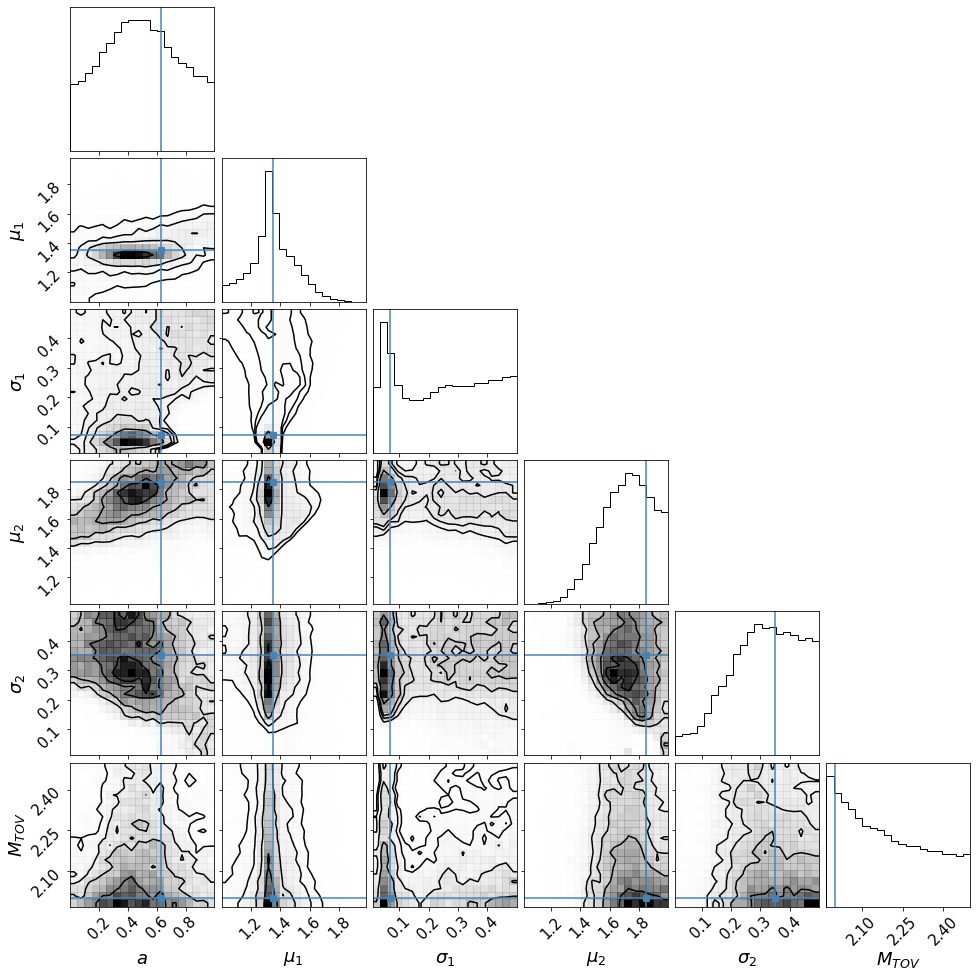

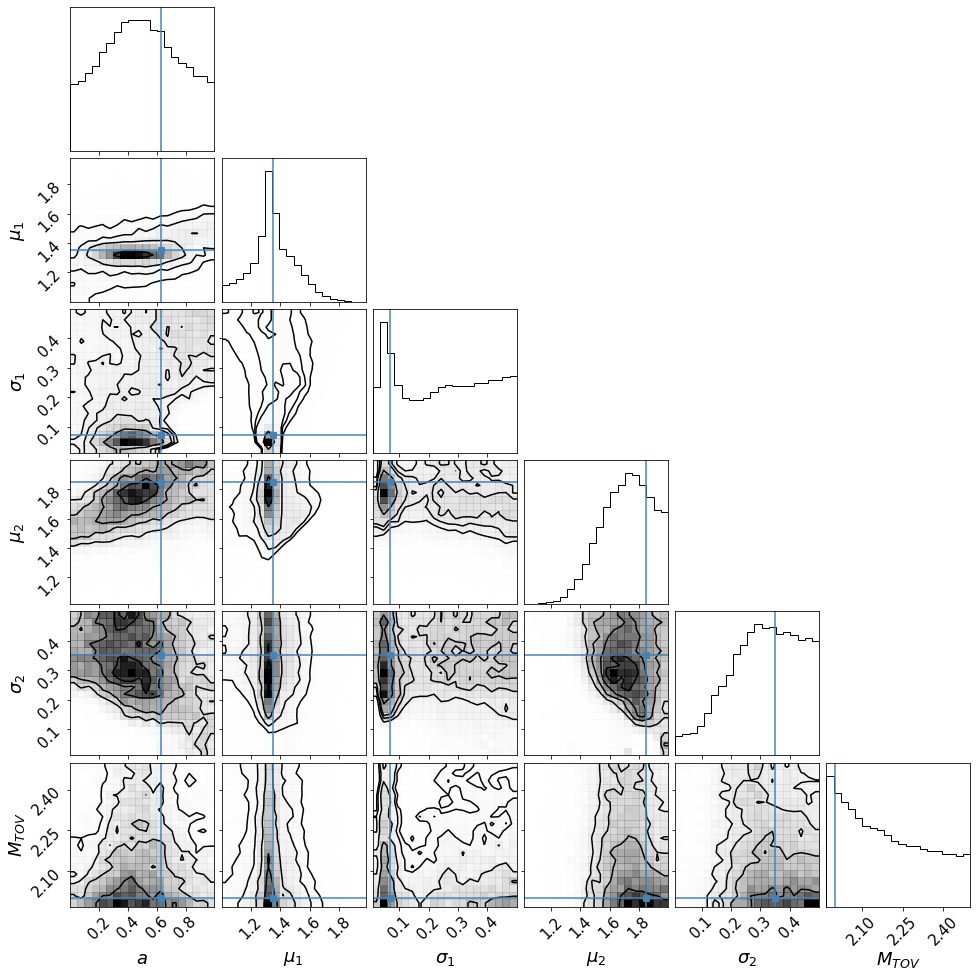

In [1260]:
corner.corner(samples, labels=['$a$', '$\mu_1$', '$\sigma_1$', '$\mu_2$', '$\sigma_2$', '$M_{TOV}$'], truths=p0, plot_datapoints=False)

In [1297]:
test = spin_mass_samples_two_mcmc(10, 2, 0.63, 1.35, 0.07, 1.85, 0.35, n=500, max_jjkep=1, return_p0=False)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


In [1299]:
p0 = [0.63, 1.35, 0.07, 1.85, 0.35, 2.0]
pscale = [0.05, 0.1, 0.01, 0.1, 0.05, 0.1]

pos = p0 + pscale*np.random.randn(12, 6)
nwalkers, ndim = pos.shape

In [ ]:
#filename = "onepeaked_withspin.h5"
#backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_one, args=([test]))
sampler.run_mcmc(pos, 5000, progress=True)
samples = sampler.get_chain(discard = 100, flat=True)
log_prob_samples = sampler.get_log_prob(discard = 100, flat=True)

In [1316]:
%timeit truncnormal_like_one(3, 5, 1, 0, 10)

20.9 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [1312]:
import scipy.stats as st

In [1314]:
a, b = (0-5)/1, (10-5)/1

In [1317]:
%timeit st.truncnorm.pdf(3, a, b, loc=5, scale=1)

385 µs ± 38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
